In [1]:
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, setup_chat_format

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import re

import os

/home/hda12228/botox/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-09-05 08:35:09.851118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 08:35:09.866122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 08:35:09.866147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 08:35:09.877512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following

In [2]:
# Count GPUs
print("Available GPUs:", torch.cuda.device_count())

# Set CUDA_VISIBLE_DEVICES to use only GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Count GPUs again to see if the change took effect
print("Available GPUs after setting CUDA_VISIBLE_DEVICES:", torch.cuda.device_count())

# Move the model to the appropriate device
device = torch.device("cuda:1") 
print("Using device:", device)

Available GPUs: 1
Available GPUs after setting CUDA_VISIBLE_DEVICES: 1
Using device: cuda:1


In [50]:
seed = 42

data = pd.read_csv('training_set_hate_speech.tsv',  delimiter='\t')
data.reset_index(drop=True, inplace=True)

data_target_val = pd.read_csv('final_test_set.tsv',  sep='\t')

system_message = """
Definiere, ob der Kommentar Hassrede enthält
0 - Keine Hassrede
1 - Enthält Hassrede
"""

dataset_tr, dataset_val = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=seed)

def convert_dataset(data):
    prompt= [{"role": "system", "content": system_message}, 
             {"role": "user", "content": str(data["text"])},
             {"role": "assistant", "content": str(data["label"])}]
    return {'messages': prompt}

dataset_tr = Dataset.from_pandas(dataset_val)
dataset_val = Dataset.from_pandas(dataset_val)
dataset_target_val = Dataset.from_pandas(data_target_val)

dataset_tr = dataset_tr.map(convert_dataset, remove_columns=dataset_tr.features)
dataset_val = dataset_val.map(convert_dataset, remove_columns=dataset_val.features)
dataset_target_val = dataset_target_val.map(convert_dataset, remove_columns=dataset_target_val.features)

print(dataset_target_val[1]["messages"])

Map:   0%|          | 0/5269 [00:00<?, ? examples/s]

Map:   0%|          | 0/5269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1997 [00:00<?, ? examples/s]

[{'content': '\nDefiniere, ob der Kommentar Hassrede enthält\n0 - Keine Hassrede\n1 - Enthält Hassrede\n', 'role': 'system'}, {'content': 'ja wer heute noch grün wählt, kann auch gleich abdampfen, rene benko freund scholz wird kanzler, lang ohne abschluss wird ministerin, bearbock hat im lebenslauf gelogen mit ihren 2 jahren studium in england. da spricht nen 3 jähriger besseres englisch. und was wird sie, natürlich aussenminister. betrug lüge und wirtschaften in die eigene tasche. egal welche partei, dass sind alles verbrecher und nur solche werden sich immer wieder durchsetzen. solange man nicht anfängt, lügenpolitik und lobbyisten-polotik unter strafe zu stellen. das land geht bergab, aber unsere regierung hält es für wichtiger, auslandsprojekte im 3 stelligen millionenbereich zu unterstützen aber hier bekommt der rentner nach 45 jahre aufn bau, nen verfickten arschtritt als rente und den arschtritt gibts monatlich, aber sich selber wieder die diäten erhöhen, diese korrupte drecksre

In [4]:
PATH = '/media/data/uv/Meta-Llama-3-8B-Instruct'
FT_PATH = "/media/data/uv/llama-8b-hate-ft"

In [ ]:
llama_tokenizer = AutoTokenizer.from_pretrained(PATH, trust_remote_code=True)
llama_tokenizer.padding_side = "right"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    #load_in_8bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False
)

base_model = AutoModelForCausalLM.from_pretrained(
    PATH,
    quantization_config=quant_config,
    device_map={"": 0}
)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

model, tokenizer = setup_chat_format(base_model, llama_tokenizer)

peft_parameters = LoraConfig(
    lora_alpha=256,
    lora_dropout=0.1,
    r=256,
    bias="none",
    task_type="CAUSAL_LM"

)

train_params = TrainingArguments(
    output_dir="/media/data/uv/llama-8b-hate-ft/results",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim='paged_adamw_32bit',
    save_steps=100,
    logging_steps=100,
    learning_rate=2e-3,
    weight_decay=1e-4,
    max_grad_norm=1.0,
    warmup_ratio=0.0,
    group_by_length=True,
    lr_scheduler_type='linear',
    seed=seed
)

ft = SFTTrainer(
    model=model,
    train_dataset=dataset_tr,
    peft_config=peft_parameters,
    tokenizer=tokenizer,
    args=train_params,
    max_seq_length=512,
)

ft.train()
ft.model.save_pretrained(FT_PATH)
tokenizer.save_pretrained(FT_PATH)

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

In [ ]:
del model, tokenizer, llama_tokenizer, ft, base_model

In [ ]:
merged_model_path = "/media/data/uv/llama-8b-hate-merged"

base_model = AutoModelForCausalLM.from_pretrained(PATH, low_cpu_mem_usage=True, return_dict=True, torch_dtype=torch.float16, device_map={"": 0})
model = PeftModel.from_pretrained(base_model, FT_PATH)

model = model.merge_and_unload()
model.save_pretrained(merged_model_path)
print('The merged model saved')

In [6]:
fine_tuned_model = AutoModelForCausalLM.from_pretrained(merged_model_path)
print('The merged model uploaded')

tokenizer = AutoTokenizer.from_pretrained(PATH, trust_remote_code=True)
print('The tokenizer uploaded')

text_generator = pipeline("text-generation", model=fine_tuned_model, tokenizer=tokenizer)
print('The pipeline initialized')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The merged model uploaded


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The tokenizer uploaded
The pipeline initialized


In [59]:
generated_texts = []

for idx, data in enumerate(dataset_val):
    prompt = tokenizer.apply_chat_template(data["messages"][:2], tokenize=False, add_generation_prompt=True)

    outputs = text_generator(
        prompt,
        max_new_tokens=1,
        do_sample=True,
        temperature=0.1,
        top_k=10,
        top_p=0.1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id
    )
    print(f'The prompt for index {idx} generated')
    generated_texts.append(outputs[0]['generated_text'])
print('The test texts generated')

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 0 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 1 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 2 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 3 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 4 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 5 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 6 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 7 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 8 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 9 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 10 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 11 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 12 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 13 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 14 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 15 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 16 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 17 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 18 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 19 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 20 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 21 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 22 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 23 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 24 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 25 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 26 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 27 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 28 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 29 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 30 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 31 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 32 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 33 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 34 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 35 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 36 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 37 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 38 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 39 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 40 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 41 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 42 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 43 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 44 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 45 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 46 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 47 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 48 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 49 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 50 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 51 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 52 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 53 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 54 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 55 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 56 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 57 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 58 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 59 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 60 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 61 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 62 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 63 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 64 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 65 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 66 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 67 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 68 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 69 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 70 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 71 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 72 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 73 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 74 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 75 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 76 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 77 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 78 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 79 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 80 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 81 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 82 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 83 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 84 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 85 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 86 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 87 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 88 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 89 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 90 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 91 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 92 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 93 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 94 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 95 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 96 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 97 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 98 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 99 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 100 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 101 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 102 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 103 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 104 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 105 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 106 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 107 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 108 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 109 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 110 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 111 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 112 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 113 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 114 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 115 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 116 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 117 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 118 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 119 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 120 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 121 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 122 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 123 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 124 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 125 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 126 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 127 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 128 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 129 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 130 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 131 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 132 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 133 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 134 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 135 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 136 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 137 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 138 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 139 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 140 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 141 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 142 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 143 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 144 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 145 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 146 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 147 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 148 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 149 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 150 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 151 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 152 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 153 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 154 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 155 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 156 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 157 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 158 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 159 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 160 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 161 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 162 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 163 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 164 generated


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The prompt for index 165 generated


In [54]:
true_labels = data_target_val['label'].tolist()

predicted_labels = [int(text.split()[-1]) if text.split()[-1].isdigit() else -1 for text in generated_texts]

output= {'comment' : data_target_val['text'],
         'label' : data_target_val['label'].astype(int), 
         'pred' : predicted_labels,
                     }
    
output = pd.DataFrame(output)

In [55]:
pattern = "([^/]+$)"
match = re.search(pattern, PATH)
output.to_csv(f'predictions_{match.group(1)}_1.tsv', sep="\t")

In [56]:
df = pd.read_csv('predictions_Meta-Llama-3-8B-Instruct.tsv', sep='\t')

true_labels = df.label
predicted_labels = df.pred

Accuracy: 0.7320981472208312
F1-score: 0.7635341724025233


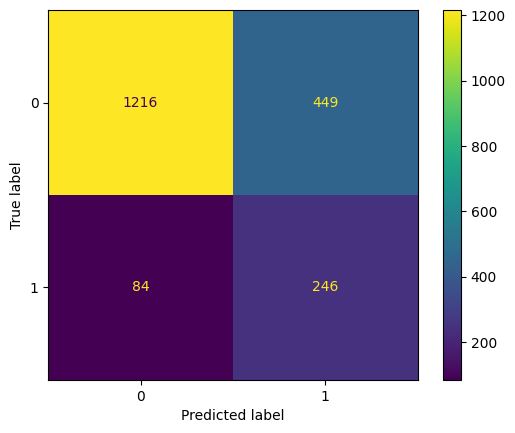

In [58]:
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

f_score = f1_score(true_labels, predicted_labels, average='weighted')
print("F1-score:", f_score)